In [11]:
#----------------------------------------Install and import necessary libraries-----------------------------------
import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer. For removing stem words
from nltk.stem import LancasterStemmer

In [12]:
import unidecode
import re
import spacy
from  nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

In [13]:
tweets = pd.read_csv('data/public_test.csv')['text']
cleaned = [preprocess(tweet, stemming=False) for tweet in tweets]

In [14]:
feed = []
cont = 0
for tweet in cleaned:
    feed += [tweet.split()]
    cont += 1

In [15]:
from gensim.models import Word2Vec
VEC_SIZE = 100

model = Word2Vec(sentences=feed, vector_size=VEC_SIZE, window=5, min_count=1, workers=4, sg=1)
model.save("word2vec.model")

In [16]:
for i in range(len(cleaned)):
    cleaned[i] = cleaned[i].split()

In [17]:
unique_words = set(feed[0])
for i in range(1, len(feed)):
    #if "" not in tweets[i]:
    unique_words.update(feed[i])
len(unique_words)

9425

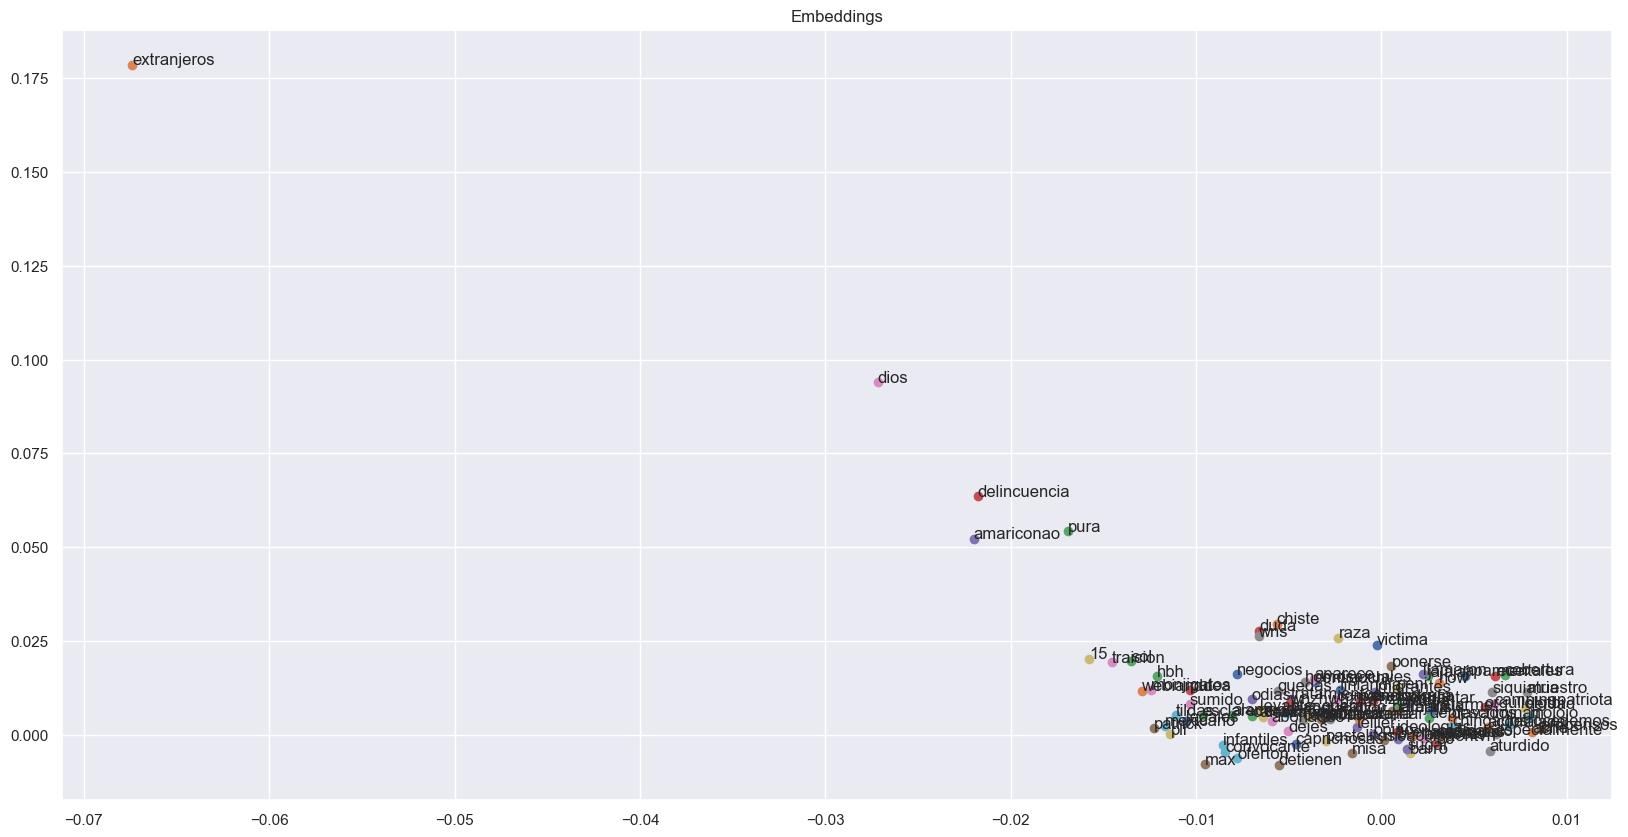

In [21]:
import matplotlib.pyplot as plt
#----------------------------------------Ploting the embeddings----------------------------------------
plt.figure(figsize=(20, 10))
import seaborn as sns
sns.set(color_codes=True)
plt.title("Embeddings")
for word in list(unique_words)[:100]:
    coord = model.wv[word] #------------------------Extracting Embeddings
    plt.scatter(coord[0], coord[1]) #-----------------------Plotting Embeddings
    plt.annotate(word, (coord[0], coord[1]))  #----------------Annotate tokens

## Gaurdar formato

In [19]:
file = open("embeddings.txt", "w")
file.write(str(len(unique_words))+" "+str(VEC_SIZE)+"\n")
for word in list(unique_words):
    coord = model.wv[word]
    file.write(word)
    for value in coord:
        file.write(" "+str(value))
    file.write("\n")

file.close()